In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from condition_prediction.run import ConditionPrediction
import wandb
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from tqdm import tqdm
import gc

2024-01-27 20:33:09.175179: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 20:33:09.217640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 20:33:09.217679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 20:33:09.218691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 20:33:09.225261: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-27 20:33:09.225735: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
api = wandb.Api()
wandb_entity="ceb-sre"
wandb_project="orderly"

## Clean up

In [ ]:
# For clean up of run config
filters = {
    "tags": {"$in": ["to_change"]}
}
runs = api.runs(f"{wandb_entity}/{wandb_project}", filters=filters)
for run in tqdm(runs):
    wandb_run = wandb.init(
        id=run.id,
        resume="allow",
        project=wandb_project,
        entity=wandb_entity,
    )
    wandb_run.config.update({"dataset_version": "v5"})
    wandb_run.finish(quiet=True)

In [ ]:
# Rerunning failed runs
BASE_PATH = pathlib.Path("/teamspace/studios/orderly-preprocessing/ORDerly/")
DATASETS_PATH = BASE_PATH / "data/orderly/datasets/"
MODEL_PATH = pathlib.Path("ORDerly/models/")
dataset = "no_trust_with_map"
filters = {
    # "state": "crashed",
    "config.output_folder_path": {
        "$in": [
            f"models/{dataset}",
            str(MODEL_PATH / dataset),
            f"/Users/Kobi/Documents/Research/phd_code/ORDerly/models/{dataset}",
        ],
    },
    "config.random_seed": 12345,
    "config.train_fraction": 0.2,
    "config.dataset_version": "v4",
    "config.train_mode": 0,  # Teacher forcing
}
# filters = {
#     "id": {"$in": ["zl4inibc", "mdwxixa4", "zbx7fqj5"]}
# }
runs = api.runs(f"{wandb_entity}/{wandb_project}", filters=filters)
# if not len(runs) == 5: # For 5 training fractions
#     raise ValueError(f"Not 5 runs for {dataset} (found {len(runs)}, seed {random_seed})")

for run in runs:
    config = dict(run.config)
    train_data_path = pathlib.Path(
        f"{DATASETS_PATH}/orderly_{dataset}_train.parquet"
    )
    test_data_path = pathlib.Path(
        f"{DATASETS_PATH}/orderly_{dataset}_test.parquet"
    )
    fp_directory = train_data_path.parent / "fingerprints"
    train_fp_path = fp_directory / (train_data_path.stem + ".npy")
    test_fp_path = fp_directory / (test_data_path.stem + ".npy")
    output_folder_path = MODEL_PATH / dataset
    output_folder_path.mkdir(parents=True, exist_ok=True)
    tags = dataset.split("_")
    tags = [f"{tags[0]}_{tags[1]}", f"{tags[2]}_{tags[3]}"]
    config.update(
        {
            "train_data_path": train_data_path,
            "test_data_path": test_data_path,
            "train_fp_path": train_fp_path,
            "test_fp_path": test_fp_path,
            "output_folder_path": output_folder_path,
            "skip_training": True,
            "resume": True,
            "resume_from_best": True,
            "generate_fingerprints": False,
            "wandb_run_id": run.id,
            "wandb_tags": tags,
        }
    )
    del config["n_val"]
    del config["n_test"]
    del config["n_train"]
    del config["dataset_version"]
    instance = ConditionPrediction(**config)
    instance.run_model_arguments()
    wandb.finish()
    gc.collect()

In [12]:
len(runs)

0

## Generate Table for dataset v5

In [5]:
DATASETS = ["with_trust_with_map","with_trust_no_map","no_trust_with_map", "no_trust_no_map", "with_trust_no_min_freq"]
lines = ["Solvents", "Agents", "Solvents \& Agents"]
top_n = 3
for dataset in DATASETS:
    filters = {
        "state": "finished",
        "config.output_folder_path": f"models/{dataset}",
        "config.random_seed": 12345,
        "config.train_fraction": 1.0,
        "config.train_mode": 0, # Teacher forcing
        "config.dataset_version": "v6"
    }
    runs = api.runs(
        f"{wandb_entity}/{wandb_project}",
        filters=filters
    )
    run = runs[0]
    if len(runs)>0:
        for r in runs:
            if run.config["dataset_version"] == "v5":
                run = r
                break

    # Get model solvent, agent and overall accuracy
    test_best = run.summary["test_best"]
    solvent_accuracy = test_best[f"solvent_accuracy_top{top_n}"]
    agent_accuracy = test_best[f"three_agents_accuracy_top{top_n}"]
    overall_accuracy = test_best[f"overall_accuracy_top{top_n}"]

    # Get frequency informed solvent, agent and overall accuracy
    fi_solvent_accuracy = run.summary[f"frequency_informed_solvent_accuracy_top_{top_n}"]
    fi_agent_accuracy = run.summary[f"frequency_informed_agent_accuracy_top_{top_n}"]
    fi_overall_accuracy = run.summary[f"frequency_informed_overall_accuracy_top_{top_n}"]

    # Improvement
    solvent_improvement = (solvent_accuracy-fi_solvent_accuracy)/(1-fi_solvent_accuracy)
    solvent_improvement_color = "lessgreen" if solvent_improvement>0 else "red"
    agent_improvement = (agent_accuracy-fi_agent_accuracy)/(1-fi_agent_accuracy)
    agent_improvement_color = "lessgreen" if agent_improvement>0 else "red"
    overall_improvement = (overall_accuracy-fi_overall_accuracy)/(1-fi_overall_accuracy)
    overall_improvement_color = "lessgreen" if overall_improvement>0 else "red"

    # Create table lines
    lines[0] += f" & {fi_solvent_accuracy*100:.0f} // {solvent_accuracy*100:.0f} // \\textcolor{{{solvent_improvement_color}}}{{{solvent_improvement*100:.0f}\%}} "
    lines[1] += f" & {fi_agent_accuracy*100:.0f} // {agent_accuracy*100:.0f} // \\textcolor{{{agent_improvement_color}}}{{{agent_improvement*100:.0f}\%}} "
    lines[2] += f" & {fi_overall_accuracy*100:.0f} // {overall_accuracy*100:.0f} // \\textcolor{{{overall_improvement_color}}}{{{overall_improvement*100:.0f}\%}} "
print("\\\\ \n".join(lines) + "\\\\")

Solvents & 57 // 70 // \textcolor{lessgreen}{31\%}  & 58 // 71 // \textcolor{lessgreen}{31\%}  & 36 // 51 // \textcolor{lessgreen}{24\%}  & 35 // 50 // \textcolor{lessgreen}{23\%}  & 57 // 70 // \textcolor{lessgreen}{30\%} \\ 
Agents & 91 // 94 // \textcolor{lessgreen}{26\%}  & 92 // 94 // \textcolor{lessgreen}{23\%}  & 46 // 56 // \textcolor{lessgreen}{20\%}  & 49 // 59 // \textcolor{lessgreen}{18\%}  & 91 // 93 // \textcolor{lessgreen}{22\%} \\ 
Solvents \& Agents & 52 // 67 // \textcolor{lessgreen}{32\%}  & 52 // 68 // \textcolor{lessgreen}{33\%}  & 20 // 35 // \textcolor{lessgreen}{19\%}  & 20 // 36 // \textcolor{lessgreen}{19\%}  & 51 // 66 // \textcolor{lessgreen}{32\%} \\


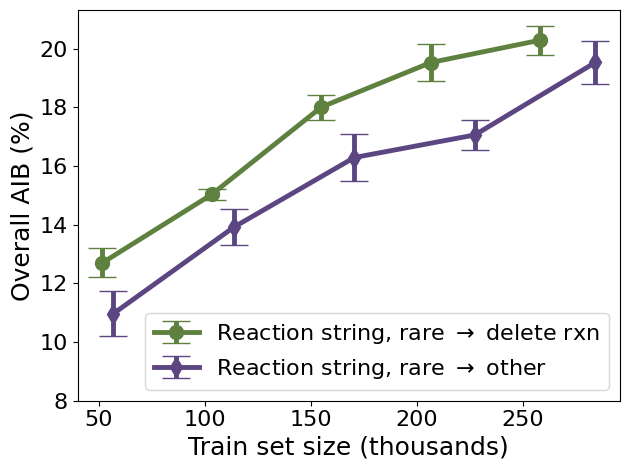

In [24]:
DATASETS = ["no_trust_no_map", "no_trust_with_map"]
LABELS = {
    "with_trust_with_map": r"Labelling, rare $\rightarrow$ other",
    "with_trust_no_map": r"Labelling, rare $\rightarrow$ delete rxn",
    "no_trust_with_map": r"Reaction string, rare $\rightarrow$ other",
    "no_trust_no_map": r"Reaction string, rare $\rightarrow$ delete rxn",
}
TRAIN_FRACS =  [0.2, 0.4, 0.6, 0.8, 1.0]
fig, ax = plt.subplots(1)
markers = ["o", "d", "s", "^"]
top_n = 3
colors = {
    "no_trust_with_map": "#5C4682",
    "no_trust_no_map": "#5e813f",
}
for i, dataset in enumerate(DATASETS):
    overall_accuracies = []
    overall_accuracies_std = []
    n_train = []
    for train_fraction in TRAIN_FRACS:
        filters = {
            "state": "finished",
            "config.output_folder_path": f"models/{dataset}",
            # "config.random_seed": {"$in": [12345, 54321, 98765]},
            # "config.random_seed": 54321,
            "config.train_fraction": train_fraction,
            "config.train_mode": 0, # Teacher forcing
            "config.dataset_version": "v5",
        }
        runs = api.runs(
            f"{wandb_entity}/{wandb_project}",
            filters=filters
        )
        # print(f"Number of runs: {len(runs)}")
        assert len(runs)==3
        

        # Get overall accuracy
        acc_local = []
        for run in runs:
            overall_accuracy = run.summary[f"test_best"][f"overall_accuracy_top{top_n}"]
            fi_overall_accuracy = run.summary[f"frequency_informed_overall_accuracy_top_{top_n}"]
            overall_improvement = (overall_accuracy-fi_overall_accuracy)/(1-fi_overall_accuracy)
            acc_local.append(overall_improvement)
        acc_local = np.array(acc_local)
        overall_accuracies.append(np.mean(acc_local*100))
        overall_accuracies_std.append(np.std(acc_local*100))
        n_train.append(run.config["n_train"])
    
    # Add line to plot
    label = LABELS[dataset]
    ax.errorbar(
        # TRAIN_FRACS,
        np.array(n_train)/ 1e3, 
        overall_accuracies,
        yerr=overall_accuracies_std,
        label=label, 
        linewidth=3.5, 
        marker=markers[i], 
        markersize=10,
        capsize=10,
        # elinewidth=10,
        color=colors[dataset]
    )

# Formatting
axis_fontsize = 16
heading_fontsize = 18
ax.legend(loc="lower right", fontsize=axis_fontsize)
ax.set_xlabel("Train set size (thousands)", fontsize=heading_fontsize)
ax.set_ylabel("Overall AIB (%)",  fontsize=heading_fontsize)
# ax.set_xticks(TRAIN_FRACS)
# ax.set_xticklabels(ax.gefontsize=axis_fontsize)
ax.tick_params(labelsize=axis_fontsize)
# ax.ticklabel_format( style='sci',scilimits=(4,4))
ylabels = np.arange(8, 22, 2)
ax.set_yticks(ylabels)
ax.set_yticklabels([f"{ylabel:.0f}" for ylabel in ylabels], fontsize=axis_fontsize)
fig.tight_layout()
fig.savefig("scaling_behavior.png", dpi=300)

In [25]:
DATASETS = ["with_trust_with_map","with_trust_no_map","no_trust_with_map", "no_trust_no_map"]
LABELS = {
    "with_trust_with_map": r"Labelling, rare $\rightarrow$ other",
    "with_trust_no_map": r"Labelling, rare $\rightarrow$ delete rxn",
    "no_trust_with_map": r"Reaction string, rare $\rightarrow$ other",
    "no_trust_no_map": r"Reaction string, rare $\rightarrow$ delete rxn",
}
TRAIN_FRACS =  [0.2, 0.4, 0.6, 0.8, 1.0]
markers = ["o", "d", "s", "^"]
top_n = 3
# colors = {
#     "no_trust_with_map": "#5C4682",
#     "no_trust_no_map": "#5e813f",
# }
overall_accuracies = []
overall_accuracies_std = []
for i, dataset in enumerate(DATASETS):
    n_train = []
    filters = {
        "state": "finished",
        "config.output_folder_path": f"models/{dataset}",
        "config.train_fraction": 1.0,
        "config.train_mode": 0, # Teacher forcing
        "config.dataset_version": "v5",
    }
    runs = api.runs(
        f"{wandb_entity}/{wandb_project}",
        filters=filters
    )
    run = runs[0]
    len(runs) == 3 # number of random seeds

    # Get overall accuracy
    acc_local = []
    for run in runs:
        overall_accuracy = run.summary[f"test_best"][f"overall_accuracy_top{top_n}"]
        fi_overall_accuracy = run.summary[f"frequency_informed_overall_accuracy_top_{top_n}"]
        overall_improvement = (overall_accuracy-fi_overall_accuracy)/(1-fi_overall_accuracy)
        acc_local.append(overall_improvement)
    acc_local = np.array(acc_local)
    overall_accuracies.append(np.mean(acc_local*100))
    overall_accuracies_std.append(np.std(acc_local*100))
    n_train.append(run.config["n_train"])

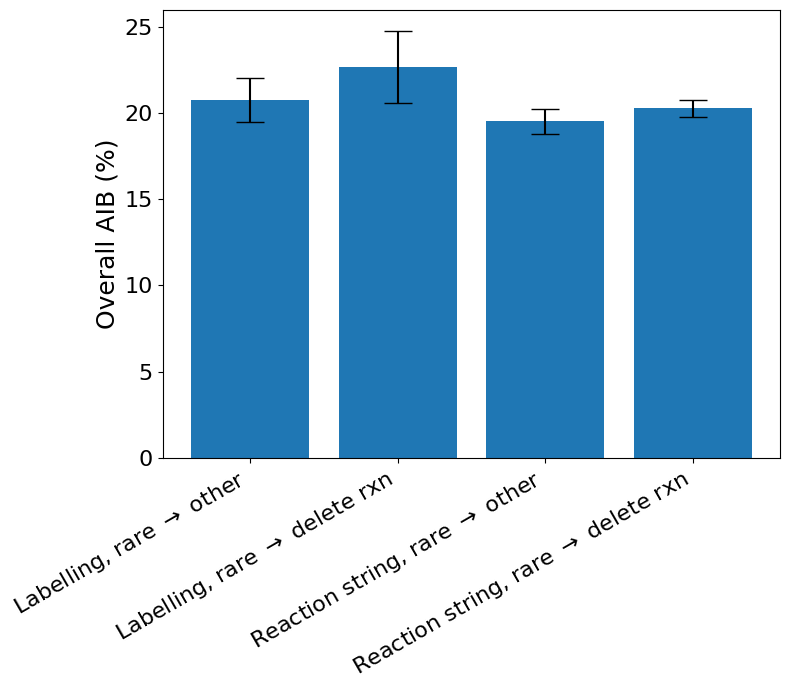

In [58]:
fig, ax = plt.subplots(1, figsize=(8,7))
# # Add line to plot
# label = LABELS[dataset]
ax.bar(
    [LABELS[d] for d in DATASETS], 
    overall_accuracies, 
    yerr=overall_accuracies_std,
    capsize=10,
    # ha="right",
    align="center",
)
for label in ax.get_xticklabels():
  label.set_rotation(30)
  label.set_ha('right')
axis_fontsize = 16
heading_fontsize = 18
# ax.legend(loc="lower right", fontsize=axis_fontsize)
ax.set_ylabel("Overall AIB (%)",  fontsize=heading_fontsize)
# ax.sex.gefontsize=axis_fontsize)
ax.tick_params(labelsize=axis_fontsize)
fig.tight_layout()
fig.savefig("dataset_comparision.png", dpi=300)